# imports

In [ ]:
!pip install huggingface_hub
!pip install torch_geometric

In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip cache purge
!pip install torch torchvision torchaudio

import torch

In [4]:
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import time
from tqdm import tqdm
import os

from shapely.geometry import LineString, Polygon, Point
import shapely


# read

file with travel mode choice info for every census tract with territory (polygons)

In [ ]:
gdf_data_polygons = gpd.read_file("data//gdf_data_polygons.geojson")
gdf_data_polygons = gdf_data_polygons.dropna(subset=['Estimate!!Total:'])

In [6]:
gdf_data_polygons.head(2)

,Geography,Geographic Area Name,Estimate!!Total:,"Estimate!!Total:!!Car, truck, or van:","Estimate!!Total:!!Car, truck, or van:!!Drove alone","Estimate!!Total:!!Car, truck, or van:!!Carpooled:","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 2-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 3-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 4-or-more-person carpool",Estimate!!Total:!!Public transportation:,Estimate!!Total:!!Public transportation:!!Bus,Estimate!!Total:!!Public transportation:!!Subway or elevated rail,Estimate!!Total:!!Public transportation:!!Long-distance train or commuter rail,"Estimate!!Total:!!Public transportation:!!Light rail, streetcar or trolley (carro público in Puerto Rico)",Estimate!!Total:!!Public transportation:!!Ferryboat,Estimate!!Total:!!Bicycle,Estimate!!Total:!!Walked,"Estimate!!Total:!!Taxi or ride-hailing services, motorcycle, or other means",Estimate!!Total:!!Worked from home,geometry
0,1400000US01001020100,Census Tract 201; Autauga County; Alabama,803,787,691,96,96,0,0,0,0,0,0,0,0,0,0,0,16,"POLYGON ((-86.5091 32.47349, -86.50577 32.4757..."
1,1400000US01001020200,Census Tract 202; Autauga County; Alabama,977,763,762,1,1,0,0,0,0,0,0,0,0,0,5,0,209,"POLYGON ((-86.48122 32.47645, -86.48093 32.481..."


In [7]:
gdf_data_polygons.describe()

,Geography,Geographic Area Name,Estimate!!Total:,"Estimate!!Total:!!Car, truck, or van:","Estimate!!Total:!!Car, truck, or van:!!Drove alone","Estimate!!Total:!!Car, truck, or van:!!Carpooled:","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 2-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 3-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 4-or-more-person carpool",Estimate!!Total:!!Public transportation:,Estimate!!Total:!!Public transportation:!!Bus,Estimate!!Total:!!Public transportation:!!Subway or elevated rail,Estimate!!Total:!!Public transportation:!!Long-distance train or commuter rail,"Estimate!!Total:!!Public transportation:!!Light rail, streetcar or trolley (carro público in Puerto Rico)",Estimate!!Total:!!Public transportation:!!Ferryboat,Estimate!!Total:!!Bicycle,Estimate!!Total:!!Walked,"Estimate!!Total:!!Taxi or ride-hailing services, motorcycle, or other means",Estimate!!Total:!!Worked from home,geometry
count,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182,8182
unique,8182,8182,3064,2621,2404,654,536,252,222,416,339,219,104,80,88,162,353,260,1082,8182
top,1400000US01001020100,Census Tract 201; Autauga County; Alabama,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-86.509097 32.473488, -86.505767 32...."
freq,1,1,68,75,77,231,371,3289,4268,4001,4454,7045,7551,7794,7917,6047,2753,2533,228,1


to utm crs

In [8]:
gdf_data_polygons.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [9]:
gdf_data_polygons = gdf_data_polygons.to_crs(gdf_data_polygons.estimate_utm_crs())
gdf_data_polygons.crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# get smallest

get 10% top rows by area sorting (get smallest)

In [10]:
gdf_data_polygons_area = gdf_data_polygons.copy()

gdf_data_polygons_area['area'] = gdf_data_polygons_area.geometry.area

gdf_sorted = gdf_data_polygons_area.sort_values('area')

ten_percent_count = max(1, int(len(gdf_data_polygons_area) * 0.1))  # минимум 1 полигон

gdf_smallest = gdf_sorted.head(ten_percent_count)

In [11]:
gdf_smallest.head(2)

,Geography,Geographic Area Name,Estimate!!Total:,"Estimate!!Total:!!Car, truck, or van:","Estimate!!Total:!!Car, truck, or van:!!Drove alone","Estimate!!Total:!!Car, truck, or van:!!Carpooled:","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 2-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 3-person carpool","Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 4-or-more-person carpool",Estimate!!Total:!!Public transportation:,...,Estimate!!Total:!!Public transportation:!!Subway or elevated rail,Estimate!!Total:!!Public transportation:!!Long-distance train or commuter rail,"Estimate!!Total:!!Public transportation:!!Light rail, streetcar or trolley (carro público in Puerto Rico)",Estimate!!Total:!!Public transportation:!!Ferryboat,Estimate!!Total:!!Bicycle,Estimate!!Total:!!Walked,"Estimate!!Total:!!Taxi or ride-hailing services, motorcycle, or other means",Estimate!!Total:!!Worked from home,geometry,area
6168,1400000US06037206302,Census Tract 2063.02; Los Angeles County; Cali...,225,52,20,32,32,0,0,61,...,40,0,0,0,0,102,0,10,"POLYGON ((-5141837.311 14170997.332, -5141771....",90162.756153
6178,1400000US06037207308,Census Tract 2073.08; Los Angeles County; Cali...,863,370,342,28,20,0,8,68,...,54,0,0,0,7,130,35,253,"POLYGON ((-5140979.485 14170760.267, -5141313....",91812.210311


In [12]:
len(gdf_smallest)

818

In [13]:
gdf_smallest.crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
gdf_smallest.explore()

In [15]:
gdf_smallest_copy = gdf_smallest.copy()
gdf_smallest_copy = gdf_smallest_copy.to_crs(4269)
gdf_smallest_copy_demo = gdf_smallest_copy.head(30)

# download graph

In [16]:
ox.settings.overpass_url  = 'https://overpass-api.de/api' # default
# ox.settings.overpass_url = 'https://maps.mail.ru/osm/tools/overpass/api/'
# ox.settings.overpass_url = 'https://overpass.openstreetmap.ru/api/'

In [17]:
ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.all_oneway = False

NETWORK_TYPE = 'drive'
DELAY = 1.0
# SAVE_FILE = 'gdf_smallest_with_graphs.pkl'


def download_graph_for_polygon(polygon, network_type='drive'):
    try:
        if polygon is None or polygon.is_empty:
            return None
        G = ox.graph_from_polygon(polygon, network_type=network_type)
        G = ox.project_graph(G)
        return G
    except Exception as e:
        print(f"Ошибка при скачивании: {e}")
        return None

gdf_smallest_copy_demo['graph'] = None

indices_to_process = gdf_smallest_copy_demo.index.tolist()
total = len(indices_to_process)



start_time = time.time()
success_count = 0

for idx in tqdm(indices_to_process, desc="Скачивание графов", unit=" строк"):
    polygon = gdf_smallest_copy_demo.at[idx, 'geometry']
    graph = download_graph_for_polygon(polygon, network_type=NETWORK_TYPE)
    gdf_smallest_copy_demo.at[idx, 'graph'] = graph
    
    if graph is not None:
        success_count += 1
    
    time.sleep(DELAY)

elapsed_time = time.time() - start_time

print(f"✓ Обработка завершена!")
print(f"✓ Успешно загружено: {success_count}/{total} графов")
print(f"✓ Не удалось загрузить: {total - success_count} графов")
print(f"✓ Время выполнения: {elapsed_time/60:.2f} минут")


# gdf_smallest.to_pickle(SAVE_FILE)
# print(f"✓ Файл сохранён: {SAVE_FILE}")

Скачивание графов:   0%|          | 0/30 [00:00<?, ? строк/s]

Скачивание графов:   3%|▎         | 1/30 [00:01<00:46,  1.61s/ строк]

Ошибка при скачивании: Graph contains no edges.


Скачивание графов:  63%|██████▎   | 19/30 [00:31<00:18,  1.64s/ строк]

Ошибка при скачивании: Graph contains no edges.


Скачивание графов: 100%|██████████| 30/30 [00:50<00:00,  1.68s/ строк]

✓ Обработка завершена!
✓ Успешно загружено: 28/30 графов
✓ Не удалось загрузить: 2 графов
✓ Время выполнения: 0.84 минут


In [18]:
gdf_smallest_copy_demo = gdf_smallest_copy_demo.dropna(subset=['graph'])
len(gdf_smallest_copy_demo)

28

# classify street pattern

## download model

In [19]:
from huggingface_hub import hf_hub_download
import torch

model_path = hf_hub_download(
    repo_id="nochka/street-pattern-classifier",
    filename="best_model.pth",
    local_dir="./models"
)

## prepare data

In [21]:
from shapely.geometry import LineString, Polygon, Point
import shapely

subgraphs = {}

for idx, row in gdf_smallest_copy_demo.iterrows():
    if row['graph'] is not None:
        g = row['graph']
        G_copy = g.copy()
        all_geoms = []
        for u, v, key, data in G_copy.edges(keys=True, data=True):
            if 'geometry' not in data:
                if ('x' in G_copy.nodes[u] and 'y' in G_copy.nodes[u] and 
                'x' in G_copy.nodes[v] and 'y' in G_copy.nodes[v]):
                    line = LineString([
                        (G_copy.nodes[u]['x'], G_copy.nodes[u]['y']),
                        (G_copy.nodes[v]['x'], G_copy.nodes[v]['y'])
                    ])
                    G_copy.edges[u, v, key]['geometry'] = line
                else:
                    print('не получилось добавить геометрию ребра')
            else:
                line = data['geometry']
            all_geoms.append(line)
        
        if all_geoms:
            all_geoms_union = shapely.union_all(all_geoms)
            bbox_geom = shapely.box(*all_geoms_union.bounds)


        subgraphs[idx] = {
            'graph': G_copy,
            # 'polygon': row['geometry']
            'polygon': bbox_geom
        }


## dataset

In [22]:
import sys
sys.path.insert(0, './street-pattern-classifier')

from block_dataset import BlockDataset
dataset = BlockDataset(subgraphs)

Computing features for all subgraphs...


Processing subgraphs...: 100%|██████████| 28/28 [00:01<00:00, 19.78it/s]

Normalization...
Number of nodes: 134
Number of features: 8
Подготовлено 28 блоков с корректными признаками


## classification

In [23]:
from classification import classify_blocks
predictions_blocks, probabilities_blocks = classify_blocks(
    dataset,
    model_path=model_path,
    device='cpu'
)

Модель загружена


Processing batches: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


## plot

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def add_predictions_to_gdf(gdf, predictions_blocks, probabilities_blocks):

    gdf_with_predictions = gdf.copy()
    gdf_with_predictions['prediction'] = None
    
    num_classes = len(next(iter(probabilities_blocks.values()))) if probabilities_blocks else 7
    for i in range(num_classes):
        gdf_with_predictions[f'prob_{i}'] = None
    
    for idx in gdf_with_predictions.index:
        if idx in predictions_blocks:
            gdf_with_predictions.at[idx, 'prediction'] = predictions_blocks[idx]
            
            if idx in probabilities_blocks:
                probs = probabilities_blocks[idx]
                for i, prob in enumerate(probs):
                    gdf_with_predictions.at[idx, f'prob_{i}'] = prob
    
    return gdf_with_predictions

gdf_with_predictions = add_predictions_to_gdf(
    gdf_smallest_copy_demo, 
    predictions_blocks, 
    probabilities_blocks
)


print(gdf_with_predictions['prediction'].value_counts().sort_index())


prediction
0    16
1     3
2     5
3     4
Name: count, dtype: int64


Ошибка при построении KDE для фичи 'Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 4-or-more-person carpool', класс 2: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Ошибка при построении KDE для фичи 'Estimate!!Total:!!Public transportation:!!Long-distance train or commuter rail', класс 3: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
Ошибка при построении KDE для фичи 'Es

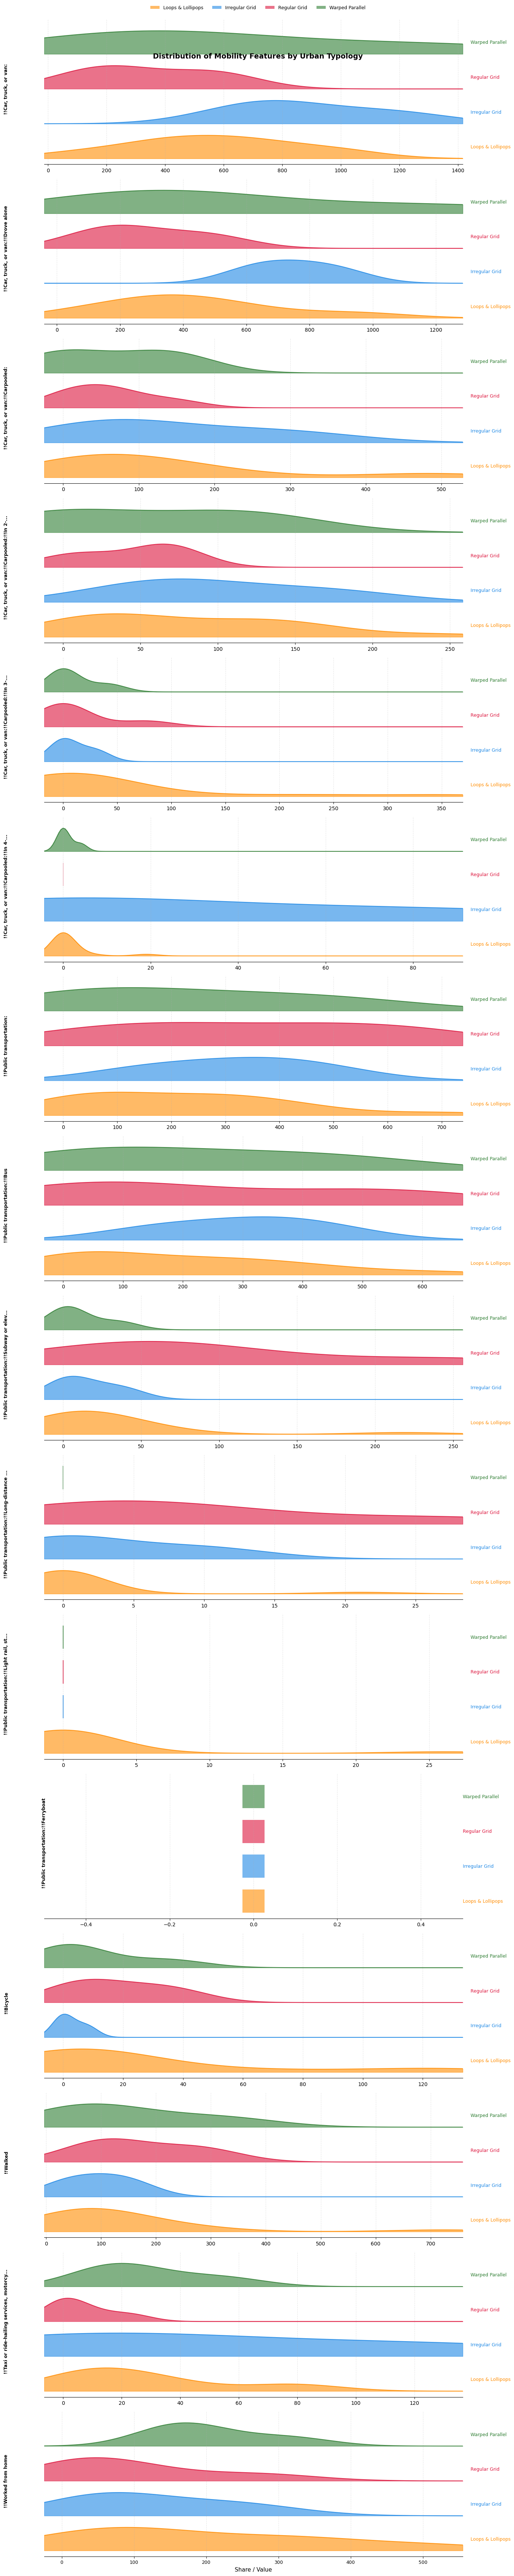

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore') 

def create_ridgeline_plots(gdf, feature_columns, predictions_col='prediction', 
                           class_names=None, figsize=(15, 10), min_samples=3):

    gdf_numeric = gdf.copy()
    for feature in feature_columns:
        if feature in gdf_numeric.columns:
            gdf_numeric[feature] = pd.to_numeric(gdf_numeric[feature], errors='coerce')
    
    classes = sorted(gdf_numeric[predictions_col].dropna().unique())
    n_classes = len(classes)
    
    colors = ['#FF8C00', '#1E88E5', '#DC143C', '#2E7D32', '#9467BD', '#FF69B4']
    
    if class_names is None:
        class_names = [f'Class {c}' for c in classes]
    
    n_features = len(feature_columns)
    
    fig, axes = plt.subplots(n_features, 1, figsize=figsize, sharex=False)
    if n_features == 1:
        axes = [axes]
    
    plt.subplots_adjust(hspace=-0.3)
    
    valid_features = []
    valid_axes = []
    
    for idx, (feature, ax) in enumerate(zip(feature_columns, axes)):
        class_data = []
        valid_classes = []
        valid_indices = []
        
        for i, class_val in enumerate(classes):
            data = gdf_numeric[gdf_numeric[predictions_col] == class_val][feature].dropna()
            
            if len(data) >= min_samples:
                class_data.append(data)
                valid_classes.append(class_val)
                valid_indices.append(i)
            else:
                print(f"Предупреждение: фича '{feature}', класс {class_val} - недостаточно данных ({len(data)} < {min_samples})")
        
        if len(class_data) == 0:
            print(f"Фича '{feature}' пропущена - нет данных ни для одного класса")
            ax.set_visible(False)
            continue
        
        valid_features.append(feature)
        valid_axes.append(ax)
        
        all_values = np.concatenate([data.values for data in class_data if len(data) > 0])
        if len(all_values) > 0:
            x_min, x_max = all_values.min(), all_values.max()
            x_range = x_max - x_min
            
            if x_range > 0:
                x_padding = x_range * 0.05
                x_limits = (x_min - x_padding, x_max + x_padding)
            else:
                x_limits = (x_min - 0.5, x_min + 0.5)
            
            x = np.linspace(x_limits[0], x_limits[1], 200)
        else:
            x_limits = (0, 1)
            x = np.linspace(0, 1, 200)
        
        for i, (class_val, data) in enumerate(zip(valid_classes, class_data)):
            if len(data) >= min_samples:
                try:
                    kde = stats.gaussian_kde(data)
                    density = kde(x)
                    density = density / density.max() * 0.8
                    offset = valid_indices[i] * 1.2
                    ax.fill_between(x, offset, offset + density, 
                                   alpha=0.6, color=colors[valid_indices[i] % len(colors)])
                    ax.plot(x, offset + density, color=colors[valid_indices[i] % len(colors)], 
                           linewidth=1.5, alpha=0.8)
                    
                except Exception as e:
                    print(f"Ошибка при построении KDE для фичи '{feature}', класс {class_val}: {e}")
                    counts, bins = np.histogram(data, bins=15, density=True)
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    offset = valid_indices[i] * 1.2
                    ax.bar(bin_centers, counts/counts.max()*0.8, width=(bins[1]-bins[0])*0.8,
                          bottom=offset, alpha=0.6, color=colors[valid_indices[i] % len(colors)],
                          align='center')
        
        if idx == 0 or True:  
            for i, class_val in enumerate(valid_classes):
                offset = valid_indices[i] * 1.2
                ax.text(x_limits[1] + x_range*0.02, offset + 0.4, 
                       class_names[valid_indices[i]], fontsize=9, 
                       color=colors[valid_indices[i] % len(colors)], 
                       verticalalignment='center')
        
        ax.set_ylim(-0.2, n_classes * 1.2)
        ax.set_yticks([])
        ax.set_ylabel('')
        
        short_name = feature.replace('Estimate!!Total:', '').strip()
        if len(short_name) > 40:
            short_name = short_name[:40] + '...'
        ax.text(x_limits[0] - x_range*0.1, n_classes * 0.6, 
               short_name, fontsize=9, fontweight='bold',
               rotation=90, verticalalignment='center',
               horizontalalignment='center')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.grid(True, alpha=0.3, axis='x', linestyle='--')
        ax.set_xlim(x_limits)
    
    if len(valid_features) == 0:
        print("Нет данных для визуализации")
        plt.close()
        return
    
    if valid_axes:
        valid_axes[-1].set_xlabel('Share / Value', fontsize=11)
        valid_axes[-1].tick_params(axis='x', labelsize=9)
    
    plt.suptitle('Distribution of Mobility Features by Urban Typology', 
                fontsize=14, fontweight='bold', y=0.98)
    
    legend_elements = []
    for i, name in enumerate(class_names[:n_classes]):
        if i < len(colors):
            legend_elements.append(plt.Rectangle((0, 0), 1, 1, 
                                                facecolor=colors[i % len(colors)], 
                                                alpha=0.6, label=name))
    
    fig.legend(handles=legend_elements, loc='upper center', 
              ncol=min(6, n_classes), bbox_to_anchor=(0.5, 1.0), 
              frameon=False, fontsize=9)
    
    plt.tight_layout()
    plt.show()

feature_columns = [
    # 'Estimate!!Total:',
    'Estimate!!Total:!!Car, truck, or van:',
    'Estimate!!Total:!!Car, truck, or van:!!Drove alone',
    'Estimate!!Total:!!Car, truck, or van:!!Carpooled:',
    'Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 2-person carpool',
    'Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 3-person carpool',
    'Estimate!!Total:!!Car, truck, or van:!!Carpooled:!!In 4-or-more-person carpool',
    'Estimate!!Total:!!Public transportation:',
    'Estimate!!Total:!!Public transportation:!!Bus',
    'Estimate!!Total:!!Public transportation:!!Subway or elevated rail',
    'Estimate!!Total:!!Public transportation:!!Long-distance train or commuter rail',
    'Estimate!!Total:!!Public transportation:!!Light rail, streetcar or trolley (carro público in Puerto Rico)',
    'Estimate!!Total:!!Public transportation:!!Ferryboat',
    'Estimate!!Total:!!Bicycle',
    'Estimate!!Total:!!Walked',
    'Estimate!!Total:!!Taxi or ride-hailing services, motorcycle, or other means',
    'Estimate!!Total:!!Worked from home'
]

# Названия классов
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
class_names = ["Loops & Lollipops", "Irregular Grid", "Regular Grid", "Warped Parallel", "Sparse", "Broken Grid"]


create_ridgeline_plots(
    gdf_with_predictions, 
    feature_columns,
    predictions_col='prediction',
    class_names=class_names,
    figsize=(14, 70),
    min_samples=2  
)

